In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import lightgbm as lgb
import optuna
import time
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Con este dataset extraeremos los datos de los incendios de 2017 para probar el modelo
bdif = pd.read_excel("bdif_modelo_2017.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


### Aplicamos mapeo de clases a la variable objetivo

In [3]:
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    339190
1    237218
2      2008
Name: count, dtype: int64

In [4]:
# Separamos el dataset para usarlo para el entrenamiento del modelo
bdif_modelo = bdif[bdif['año'] <= 2016]
bdif_modelo.shape

(570372, 30)

### Preprocesamiento de los datos

In [5]:
# Seleccionamos las variables numéricas y categóricas 
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Aplicamos las transformaciones para cada tipo de variable
prep = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False), categoricas),])

# Creamos el pipeline
pipeline = Pipeline(steps=[('prep', prep)])

# Introducimos los datos de entrada
X = bdif_modelo.drop(columns=['claseincendio'])

# Ajustar el Pipeline a los datos y transformar
X_prep = pipeline.fit_transform(X)

# Lo pasamos a dataframe
X_prepdf = pd.DataFrame(X_prep, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_prepdf.filter(regex='^cat').columns
X_prepdf[dummies] = X_prepdf[dummies].astype(int)

# Eliminamos los prefijos
X_prepdf.columns = X_prepdf.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Mostrar el resultado
X_prepdf.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,0,1,0,0,0,0,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,0,1,0,0,0,0,0,0,1
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,0,1,0,0,1,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,0,1,0,0,1,0,0,0,0,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,1,0,0,0,1,0,0,1,0,0


In [6]:
# Reconstruimos el dataset
X_prepdf['claseincendio'] = bdif_modelo['claseincendio']
bdif_reconstruido = X_prepdf.copy()
bdif_reconstruido.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde,claseincendio
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,...,0,0,0,1,0,0,0,0,1,1
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,...,0,1,0,0,0,0,0,0,1,0
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,...,0,0,0,1,0,0,1,0,0,0
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,...,1,0,0,1,0,0,0,0,1,1
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,...,0,0,0,1,0,0,1,0,0,0


In [7]:
X = bdif_reconstruido[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
y = bdif_reconstruido['claseincendio']

### Dataset submuestreado con ENN + Tomek Links

In [8]:
bdif_enn = pd.read_excel("bdif_submuestreado.xlsx")
bdif_enn.head()

,denincendios,tmax,denpoblacion,lon,lat,fuego_sup_cop,fwi,hrmedia,altitud,fuego_superficie,...,lugar_autovia_carretera,lugar_senda,detectadopor_otros,dia_festivo,mes_septiembre,combustible_pastizales,dia_sabado,combustible_bosques,horario_Mañana,claseincendio
0,0.014306,0.618875,0.000183,0.559100,0.802846,0,0.265486,0.572917,0.543093,1,...,0,0,0,0,0,1,0,0,0,0
1,0.000358,0.542650,0.000068,0.523174,0.647512,0,0.000000,0.656250,0.418536,1,...,0,1,1,0,0,1,1,0,0,0
2,0.000269,0.802178,0.000060,0.574670,0.718691,0,0.378725,0.427083,0.236128,1,...,0,0,0,0,0,0,0,0,0,0
3,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000112,0.802178,0.000010,0.587270,0.722982,0,0.378725,0.427083,0.257379,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(bdif_enn['claseincendio'].value_counts())

claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64


In [10]:
bdif_enn = bdif_enn[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]

### Dataset submuestreado con ENN y reducción controlada de clases

In [11]:
X = bdif_enn.drop(['claseincendio'], axis=1)
y = bdif_enn['claseincendio']

rus = RandomUnderSampler(sampling_strategy={0:int(1.5*y.value_counts()[2]), 1:int(1.5*y.value_counts()[2])}, random_state=42)

X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
0    2949
1    2949
2    1966
Name: count, dtype: int64


### Sobremuestreo con SMOTE

In [12]:
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']

X_train_sob, X_test, y_train_sob, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train_sob, y_train_sob)

print(f"Distribución de clases en el conjunto de entrenamiento después de smote: {Counter(y_train)}")
print(f"Distribución de clases en el conjunto de test: {Counter(y_test)}")

Distribución de clases en el conjunto de entrenamiento después de smote: Counter({2: 2366, 1: 2366, 0: 2366})
Distribución de clases en el conjunto de test: Counter({0: 618, 1: 583, 2: 372})


### Cálculos del modelo

In [296]:
# División en entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Entrenamos el modelo XGBoost
xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [20]:
# Hacemos las predicciones
y_pred = xgb.predict(X_test)

# Mostramos el informe
print(classification_report(y_test, y_pred, target_names=['conato', 'incendio', 'gif']))

              precision    recall  f1-score   support

      conato       0.92      0.93      0.93       590
    incendio       0.84      0.77      0.81       590
         gif       0.70      0.77      0.73       393

    accuracy                           0.83      1573
   macro avg       0.82      0.83      0.82      1573
weighted avg       0.84      0.83      0.83      1573



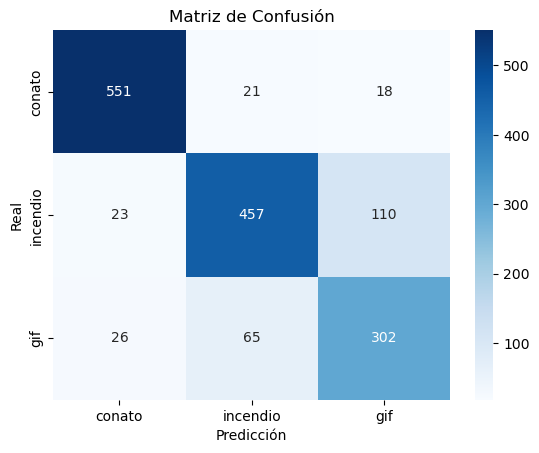

In [21]:
# Matriz de confusión con las clases ordenadas
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Creamos y mostramos la matriz mediante un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

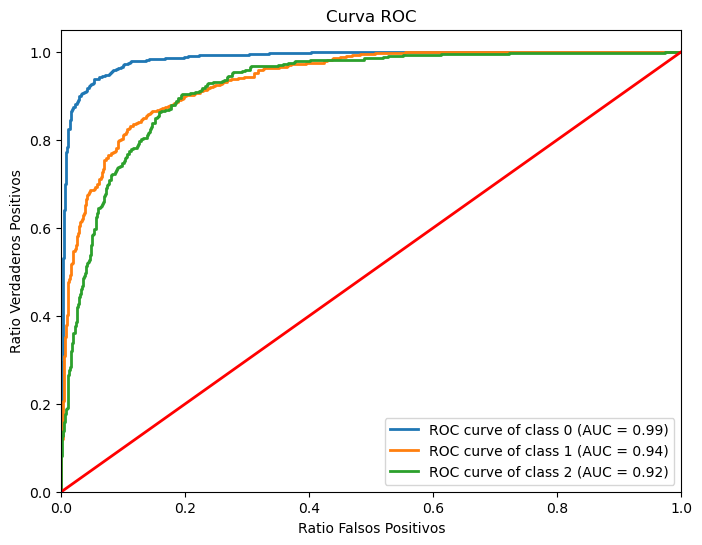

In [23]:
y_pred_prob = xgb.predict_proba(X_test)

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva roc y el auc
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el calculo del auc
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

### Mejora con optuna

In [33]:
def objective(trial):
    param = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'n_estimators': 100,
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_class': 3,  # Ajustar según las clases de tu problema
        'random_state': 42
    }

    # Modelo
    model = xgb.XGBClassifier(use_label_encoder=False, **param)

    # Entrenamiento
    model.fit(X_train, y_train)

    # Predicciones
    preds = model.predict(X_test)

    # Calcular F1 Score Macro
    f1 = f1_score(y_test, preds, average='macro')
    return f1

# Crear el estudio
study = optuna.create_study(direction='maximize')

# Optimizar
study.optimize(objective, n_trials=50)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", study.best_params)
print("Mejor F1 Score:", study.best_value)

[I 2024-12-15 20:12:31,640] A new study created in memory with name: no-name-44334151-df50-4b1c-a8cd-6e7b3adfed7b
[I 2024-12-15 20:12:32,643] Trial 0 finished with value: 0.8082920557250234 and parameters: {'learning_rate': 0.012868797444647922, 'max_depth': 13, 'subsample': 0.6183397737089735, 'colsample_bytree': 0.9882773012578315, 'gamma': 2.1328085319604244, 'min_child_weight': 4}. Best is trial 0 with value: 0.8082920557250234.
[I 2024-12-15 20:12:32,961] Trial 1 finished with value: 0.8074477388656196 and parameters: {'learning_rate': 0.03903120697767282, 'max_depth': 9, 'subsample': 0.7358208668949919, 'colsample_bytree': 0.8198559569336343, 'gamma': 4.863664160224283, 'min_child_weight': 8}. Best is trial 0 with value: 0.8082920557250234.
[I 2024-12-15 20:12:33,362] Trial 2 finished with value: 0.7889528104782334 and parameters: {'learning_rate': 0.0024247805739884905, 'max_depth': 6, 'subsample': 0.7074943062251271, 'colsample_bytree': 0.8756844932188913, 'gamma': 0.8818239762

Mejores parámetros: {'learning_rate': 0.04988363971598505, 'max_depth': 9, 'subsample': 0.5366123730207244, 'colsample_bytree': 0.8903453124684181, 'gamma': 0.5343905833890564, 'min_child_weight': 2}
Mejor F1 Score: 0.828864654286512


In [15]:
#print(f"Mejor valor objetivo: {study.best_value}")
#print(f"Mejores hiperparámetros: {study.best_params}")

#best_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',**study.best_params)

# Entrenar
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       618
           1       0.85      0.79      0.82       583
           2       0.72      0.76      0.73       372

    accuracy                           0.84      1573
   macro avg       0.83      0.83      0.83      1573
weighted avg       0.84      0.84      0.84      1573



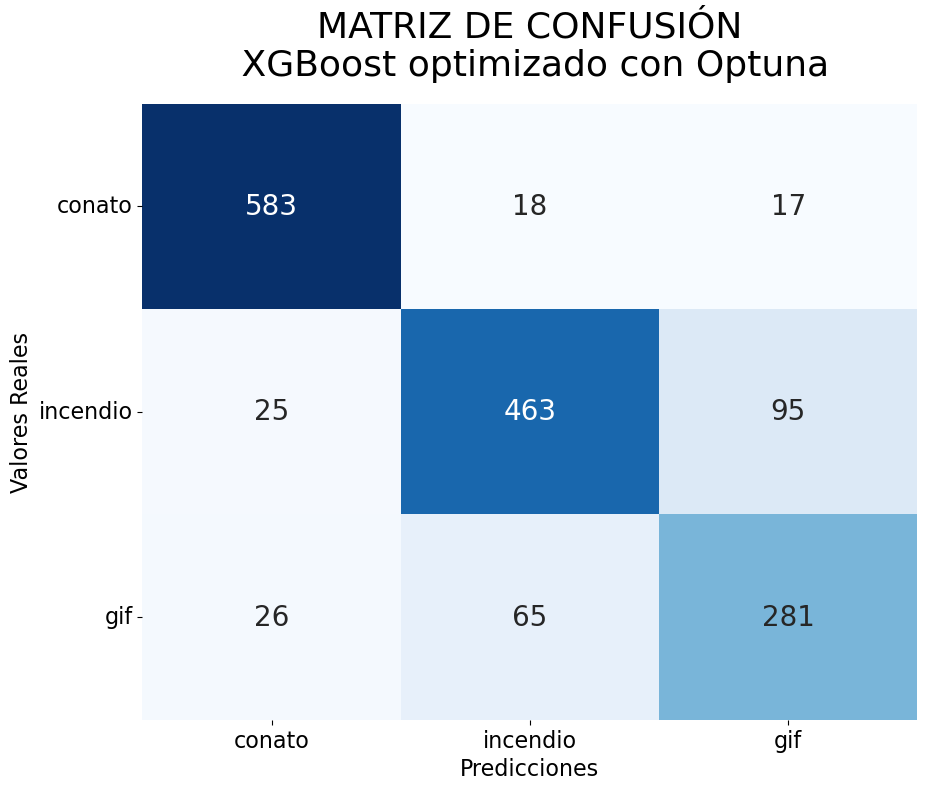

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Creamos y mostramos la matriz
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20},cbar=False)

plt.title("MATRIZ DE CONFUSIÓN\n XGBoost optimizado con Optuna", fontsize=26, pad=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

In [55]:
import joblib
joblib.dump(best_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

In [14]:
import joblib

# Cargar el modelo desde el archivo .pkl
best_model = joblib.load('best_xgb_model.pkl')

# Verificar si se cargó correctamente (opcional)
print("Modelo cargado correctamente:", best_model)

Modelo cargado correctamente: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8903453124684181, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.5343905833890564, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04988363971598505,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)


### Probamos los datos del 2017 con el mejor modelo

In [56]:
bdif_2017 = bdif[bdif['año'] == 2017]
bdif_2017.shape

(8044, 30)

In [57]:
X = bdif_2017.drop(['claseincendio'], axis=1)
y = bdif_2017['claseincendio']

rus = RandomUnderSampler(sampling_strategy='auto', random_state=36)

X_sub, y_sub = rus.fit_resample(X, y)

bdif_2017 = pd.concat([X_sub, y_sub], axis=1)

print(bdif_2017['claseincendio'].value_counts())

claseincendio
0    42
1    42
2    42
Name: count, dtype: int64


In [58]:
# Separamos las variables descriptivas de la variable objetivo
X_2017 = bdif_2017.drop(columns=['claseincendio'])
y_2017 = bdif_2017['claseincendio']

# le pasamos el pipeline a los datos de 2017
X_2017 = pipeline.transform(X_2017)

In [59]:
# Lo pasamos a dataframe
X_2017 = pd.DataFrame(X_2017, columns=pipeline.named_steps['prep'].get_feature_names_out())

# Hay que convertir las columnas categoricas a enteros
dummies = X_2017.filter(regex='^cat').columns
X_2017[dummies] = X_2017[dummies].astype(int)

# Eliminamos los prefijos
X_2017.columns = X_2017.columns.str.replace(r'^(num__|cat__)', '', regex=True)

# Mostrar el resultado
X_2017.head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,0.259839,0.116883,0.528561,0.971318,0.0,0.637024,0.333333,0.035032,0.086397,0.353356,...,1,0,0,0,0,1,0,0,0,1
1,0.088348,0.147580,0.541342,0.699433,0.0,0.825771,0.861111,0.035032,0.097426,0.765101,...,0,0,0,0,1,0,0,0,0,1
2,0.029399,0.380165,0.459479,0.897975,0.0,0.607985,0.585859,0.089172,0.178309,0.468960,...,1,0,0,0,1,0,0,0,0,1
3,0.454518,0.115702,0.739471,0.962862,0.0,0.644283,0.472222,0.025478,0.117647,0.513849,...,0,0,1,0,0,0,0,0,1,0
4,0.173057,0.365998,0.571168,0.574255,0.0,0.773140,0.777778,0.054140,0.152574,0.684564,...,1,0,0,0,1,0,0,1,0,0


In [60]:
# Filtramos la selección de características
X_2017 = X_2017[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana']]
X_2017.shape

(126, 36)

In [61]:
# Realizar predicciones con el modelo
y_pred_2017 = best_model .predict(X_2017)

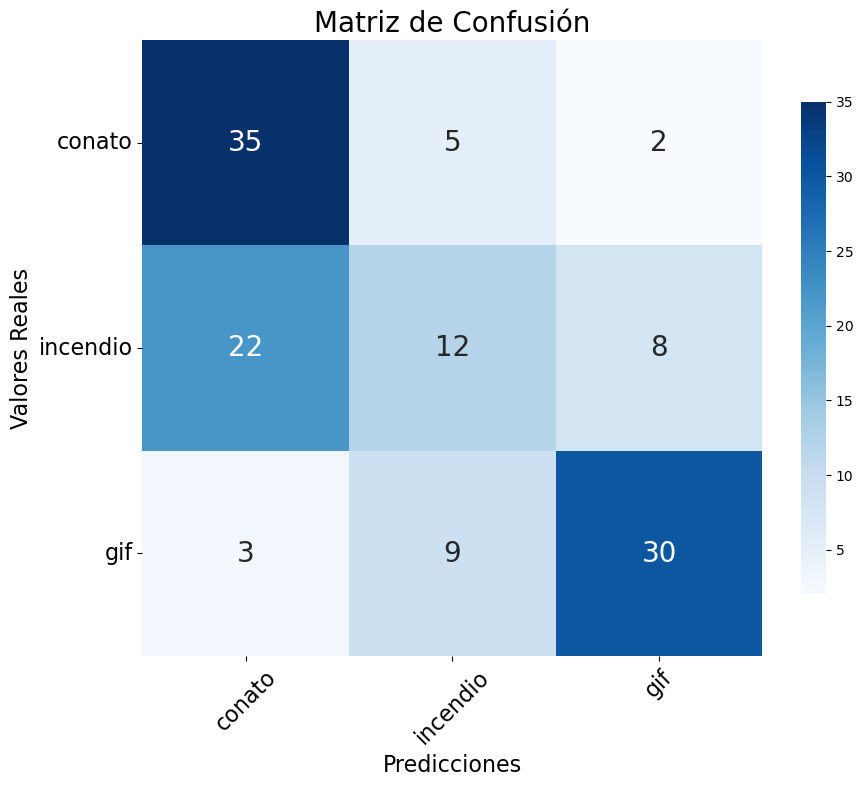

In [64]:
cm = confusion_matrix(y_2017, y_pred_2017,labels=[0, 1, 2])

# Etiquetas de las clases
etiquetas = ['conato', 'incendio', 'gif']

plt.figure(figsize=(10, 8))

# Visualizamos la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=etiquetas, yticklabels=etiquetas,
            annot_kws={"size": 20}, cbar_kws={"shrink": 0.8})

plt.title("Matriz de Confusión", fontsize=20)
plt.xlabel("Predicciones", fontsize=16)
plt.ylabel("Valores Reales", fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(rotation=0, fontsize=16)

# Mostramos la gráfica
plt.show()

In [63]:
# Mostramos el informe
print(classification_report(y_2017, y_pred_2017, target_names=['conato', 'incendio', 'gif']))

              precision    recall  f1-score   support

      conato       0.58      0.83      0.69        42
    incendio       0.46      0.29      0.35        42
         gif       0.75      0.71      0.73        42

    accuracy                           0.61       126
   macro avg       0.60      0.61      0.59       126
weighted avg       0.60      0.61      0.59       126



@inproceedings{akiba2019optuna,
  title={{O}ptuna: A Next-Generation Hyperparameter Optimization Framework},
  author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
  booktitle={The 25th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2623--2631},
  year={2019}
}

#### Fuentes de datos:

1. **AEMET**: Los datos utilizados en este análisis provienen de la **Agencia Estatal de Meteorología (AEMET)**. Los datos están sujetos a las [condiciones de uso de AEMET](https://www.aemet.es/es/portada), y deben ser utilizados con la debida citación.
2. **EGIF**: Los datos utilizados en este análisis provienen de la **Estadística General de Incendios Forestales (EGIF)**, gestionada por el **Ministerio para la Transición Ecológica y el Reto Demográfico (MITECO)**. Los datos deben ser utilizados de acuerdo con las [condiciones de uso de la EGIF](https://www.miteco.gob.es/es/biodiversidad/temas/incendios-forestales/estadisticas-datos.aspx).
3. **NGMEP (Nomenclátor Geográfico de Municipios y Entidades de Población)**: Los datos utilizados en este análisis provienen del **Nomenclátor Geográfico de Municipios y Entidades de Población (NGMEP)**, proporcionado por el **Centro Nacional de Información Geográfica (CNIG)**. Los datos están sujetos a la licencia de [Datos Abiertos del CNIG](https://astronoomia.ign.es/web/ign/portal). Se debe proporcionar citación adecuada al utilizar los datos.
4. **Climate Data Store (CDS)**: Los datos utilizados en este análisis provienen del **Climate Data Store (CDS)**, específicamente del indicador de peligro de incendio **FWI** derivado de proyecciones climáticas para Europa. Los datos están sujetos a la [licencia de uso de CDS](https://cds.climate.copernicus.eu/#!/home), y deben ser utilizados con la debida citación.
5. **INE (Instituto Nacional de Estadística)**: Los datos utilizados en este análisis provienen de las **Series de población por provincia (1900-2001)**, las **principales series de población desde 1998** y del **Código INE**. Los datos están sujetos a las [condiciones de uso del INE](https://www.ine.es/jaxiT3/Datos.htm?t=2865), y deben ser utilizados con la debida citación.